# 1) Samuel Štěpán, 209485, analysis of S&P's market value from 2000 to 2023

In [146]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.graphics.tsaplots as sgt
import statsmodels.tsa.stattools as sts
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.tsa.arima.model import ARIMA
from pmdarima.arima import auto_arima
from scipy import stats
from scipy import signal
import seaborn as sns
sns.set()

Loading time series - historical data about S&P 500 from 2000 to 2023

In [147]:
raw_data = pd.read_csv("HistoricalPrices_2000_2023.csv")
data = raw_data.copy()

In [148]:
data.tail()

,Date,Open,High,Low,Close
5712,08/14/00,1491.56,1491.58,1468.60,1491.56
5713,08/11/00,1471.84,1475.60,1452.91,1471.84
5714,08/10/00,1460.25,1475.15,1459.89,1460.25
5715,08/09/00,1472.87,1490.33,1471.16,1472.87
5716,08/08/00,1482.80,1484.52,1472.61,1482.80


Creating new table with Date(converted to date_time) as index and using only column Open(renamed as value, which shall represent market value)

In [149]:
data = pd.DataFrame(index = pd.to_datetime(data["Date"], format = "%m/%d/%y", dayfirst = True), columns = ["value"])
data.loc[:,"value"] = raw_data.loc[:," Open"]

In [150]:
data.tail()

,value
Date,
2000-08-14,1491.56
2000-08-11,1471.84
2000-08-10,1460.25
2000-08-09,1472.87
2000-08-08,1482.8


Setting frequency for all business days and checking if we lack data for some days

In [151]:
data = data.asfreq("b")

In [152]:
data.head()

,value
Date,
2000-08-08,1482.8
2000-08-09,1472.87
2000-08-10,1460.25
2000-08-11,1471.84
2000-08-14,1491.56


Cheking if there are some business days for which we do not have data and filling them with value from the day before (because on those days the stock market was probably closed so the price should not change)

In [153]:
data.isna().sum()

value    212
dtype: int64

In [154]:
data = data.fillna(method = "ffill")

In [155]:
data.isna().sum()

value    0
dtype: int64

# 2) Plotting data and autocorrelation function

Plotting data

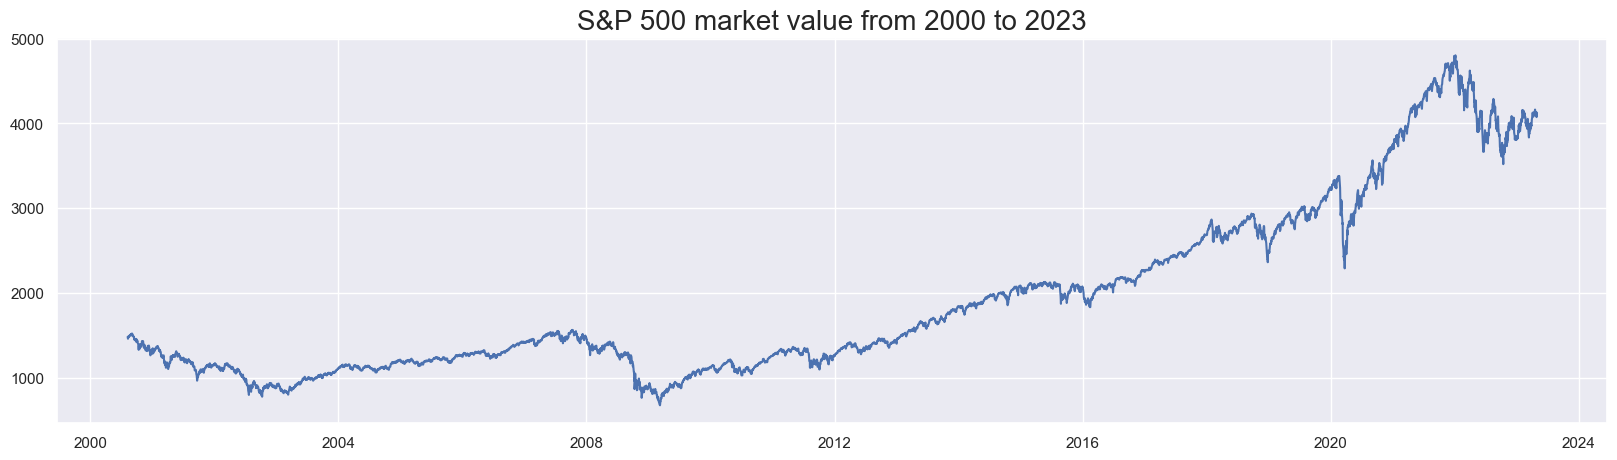

In [156]:
fig = plt.figure(figsize = (20,5))
plt.plot(data.index, data["value"])
plt.title("S&P 500 market value from 2000 to 2023", size = 20)
plt.show()

Plotting autocorrelation function

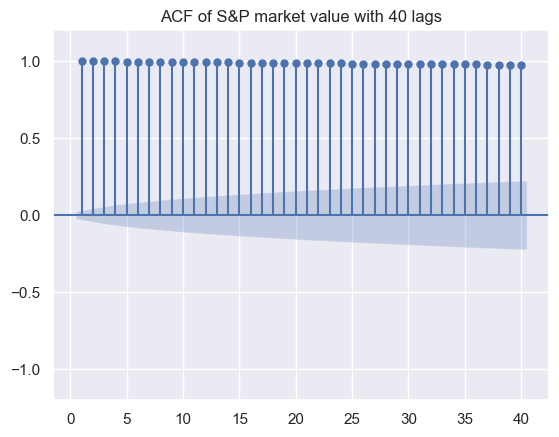

In [157]:
sgt.plot_acf(data["value"], lags = 40, zero = False, auto_ylims = False)
plt.title("ACF of S&P market value with 40 lags")
plt.ylim(-1.2, 1.2)
plt.show()

I have chosen lags = 40 based on recommendations I have found on internet. We can see that acf for all 40 lags is highly correlated and their's values are significant(the blue area marks unsignificant values). Therefore we can say that all values from previous periods could be used for prediction of the next time period.

# 3) Determining if stabilization of variance is necessary

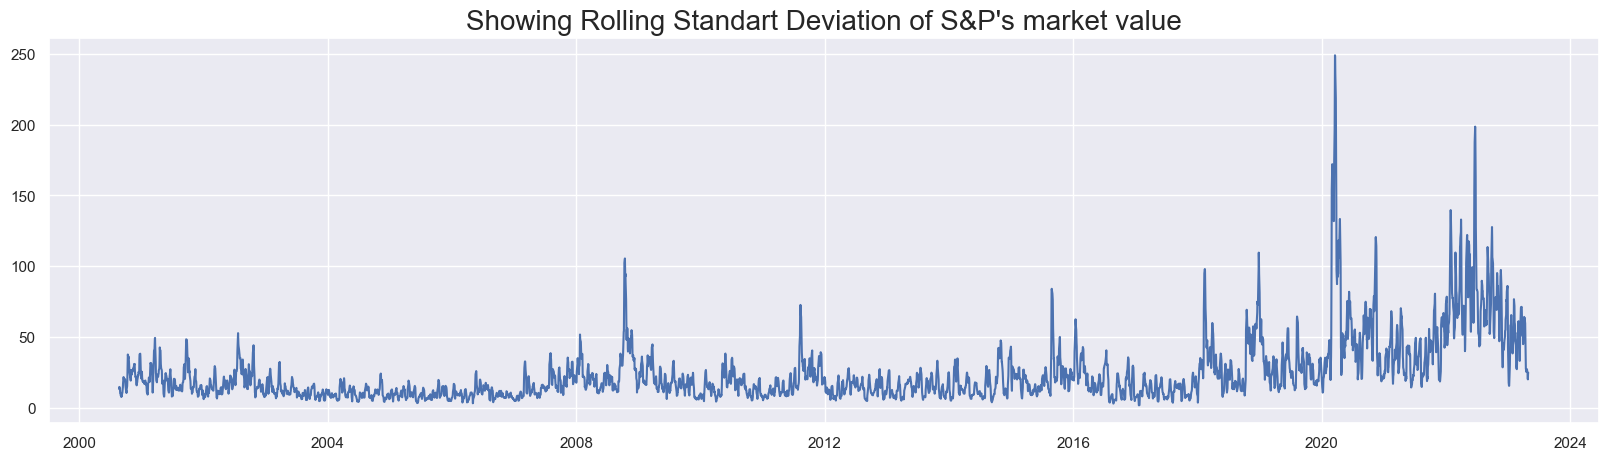

In [158]:
rolling_std = data['value'].rolling(window=12).std()

fig = plt.figure(figsize = (20,5))
plt.plot(rolling_std.index, rolling_std)
plt.title("Showing Rolling Standart Deviation of S&P's market value", size = 20)
plt.show()

From this graph we can see, that there is no clear trend in variance/standart deviation over a time series. Although we can see that since year 2018 there is some increase in variance/standart deviation. This might be because of increase in market value of S&P and unstability of stock market around covid years.

Test of stacionarity of variance (by using Dickey-Fuller test)

In [159]:
sts.adfuller(rolling_std[12:-12])

(-5.287695834858862,
 5.806314664066245e-06,
 28,
 5876,
 {'1%': -3.431463369470017,
  '5%': -2.862032005057499,
  '10%': -2.5670318921113497},
 30187.440601742957)

First number is test statistics and since it's lesser than critical values for 1%, 5% and 10% it suggests stationarity of variance. Second number is p-value and because it's close to zero it too suggests stationarity of variance. 

Trying Box-Cox transformation and showing results

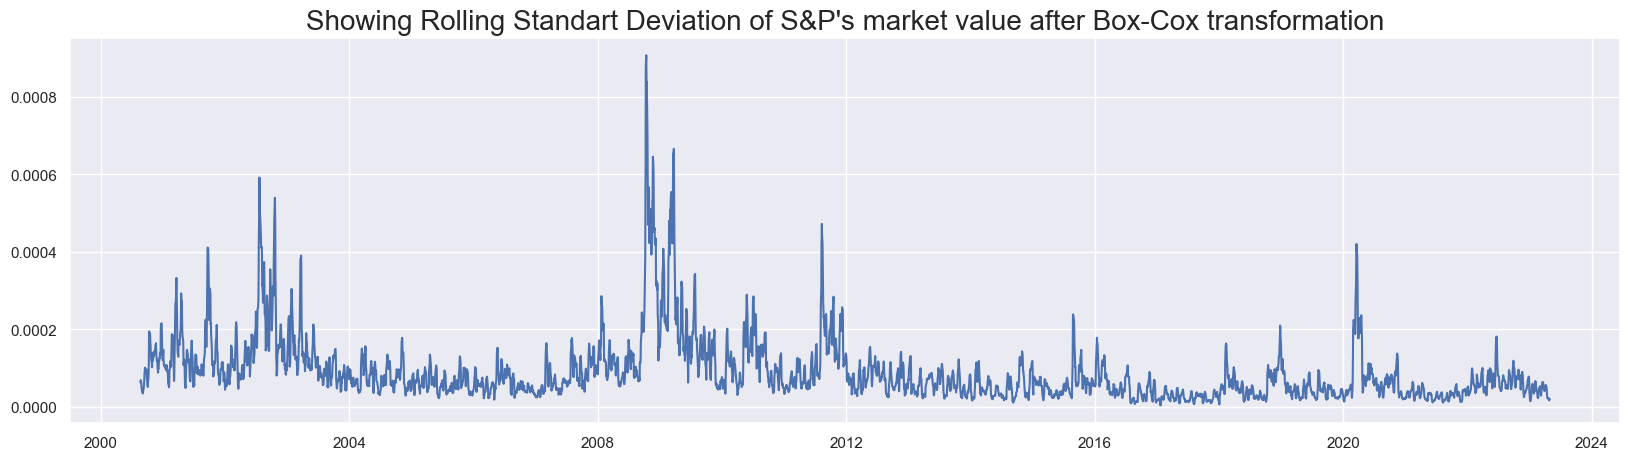

Ideal value of lambda(found by boxcox) is -0.681106705282645
Confidence interval of lambda is (-0.7405920432864924, -0.6217611622001656)


In [160]:
data['value_B_C'], lam, conf_int = stats.boxcox(data['value'], alpha = 0.05)
rolling_std_B_C = data['value_B_C'].rolling(window=12).std()

fig = plt.figure(figsize = (20,5))
plt.plot(rolling_std_B_C.index, rolling_std_B_C)
plt.title("Showing Rolling Standart Deviation of S&P's market value after Box-Cox transformation", size = 20)
plt.show()
print("Ideal value of lambda(found by boxcox) is", lam)
print("Confidence interval of lambda is", conf_int)

Plotting market value of S&P 500 after Box-Cox transformation

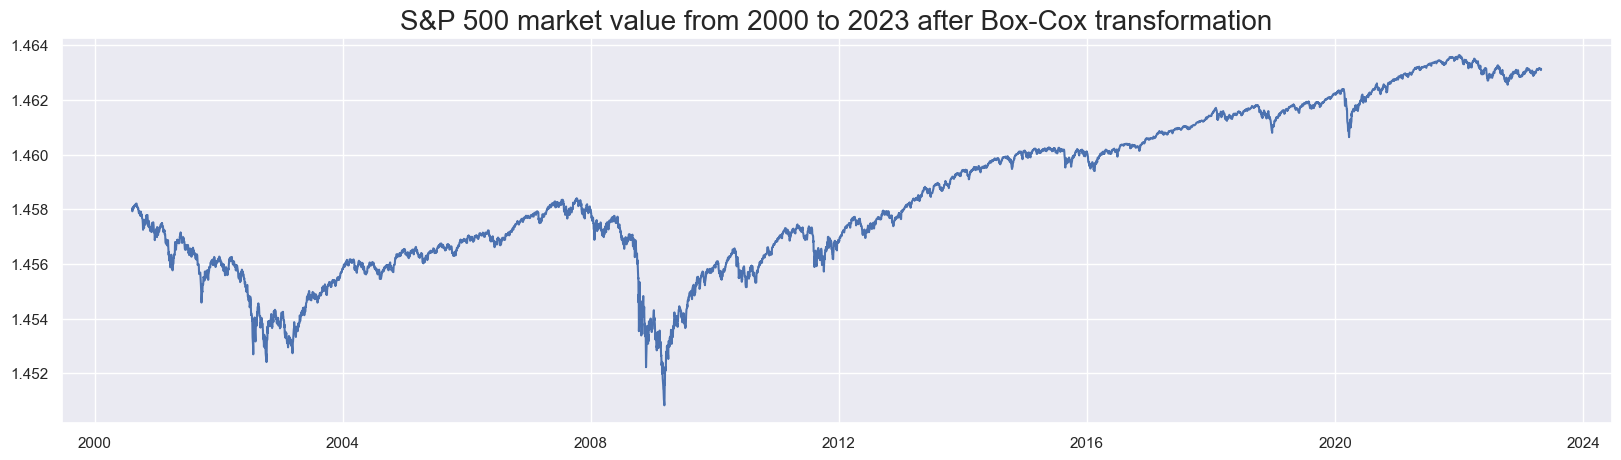

In [161]:
fig = plt.figure(figsize = (20,5))
plt.plot(data.index, data["value_B_C"])
plt.title("S&P 500 market value from 2000 to 2023 after Box-Cox transformation", size = 20)
plt.show()

We can see that variance after years 2018 is greatly improved, but at the same time variance after dotcom bubble crash(at 2001) and after financial crisis at 2008 is increased (relatively). We have also lost information about value of the S&P 500 in dolars. Considering these results and Dickey-Fuller test I suggest that transformation stabilization variance is not necessary.

# 4) Removing trend by using correct method

We can see that time series of S&P 500 market value has clearly trend and no clear seasonal component. Because from the graph is clear that there is no simple suitable function that we could use to regression, we shall try using moving average and differencing.

## Using Moving Average

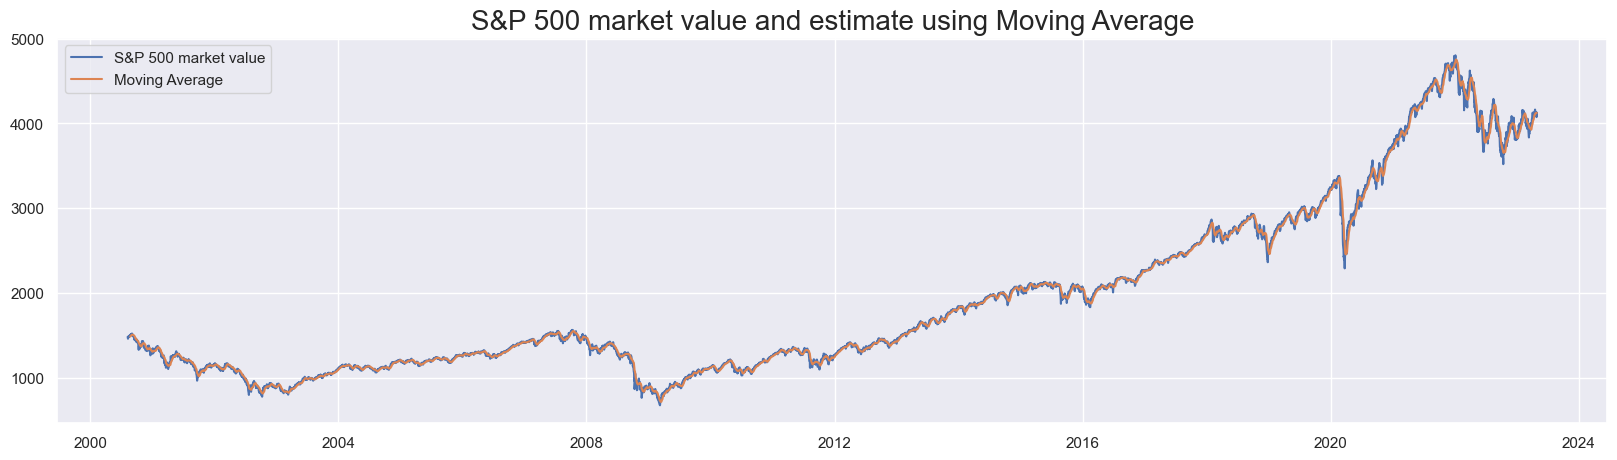

In [162]:
data["M_A"] = data['value'].rolling(window=12).mean()

fig = plt.figure(figsize = (20,5))
plt.plot(data.index, data['value'], label='S&P 500 market value')
plt.plot(data.index, data["M_A"], label='Moving Average')
plt.legend()
plt.title("S&P 500 market value and estimate using Moving Average", size = 20)
plt.show()

Showing result after substracting Moving Average estimate from S&P 500 market value

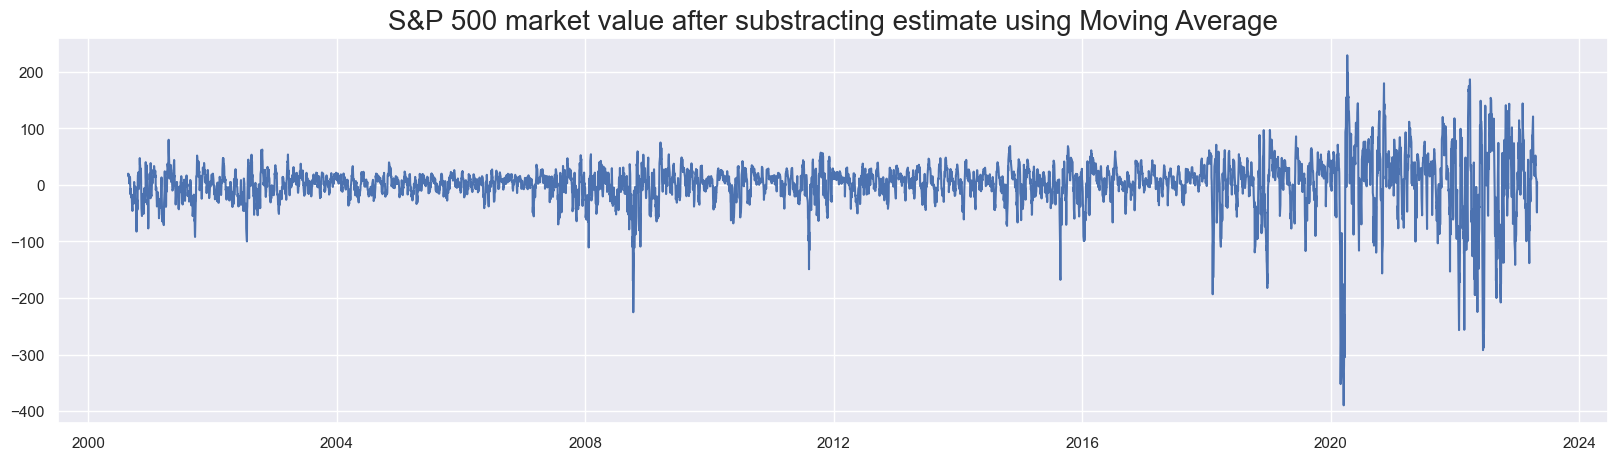

In [163]:
fig = plt.figure(figsize = (20,5))
data["subs_M_A"] = data['value'] - data["M_A"]
plt.plot(data.index, data["subs_M_A"])
plt.title("S&P 500 market value after substracting estimate using Moving Average", size = 20)
plt.show()

Testing stacionarity of market value - Moving Average (by using Dickey-Fuller test)

In [164]:
sts.adfuller(data["subs_M_A"][12:-12])

(-13.40467129723902,
 4.494906923789202e-25,
 32,
 5872,
 {'1%': -3.431464128228021,
  '5%': -2.8620323402946677,
  '10%': -2.5670320705674277},
 52056.84556820095)

We can see that Dickey-Fuller test suggests stationarity (so we have successfully removed trend)

## Using differencing

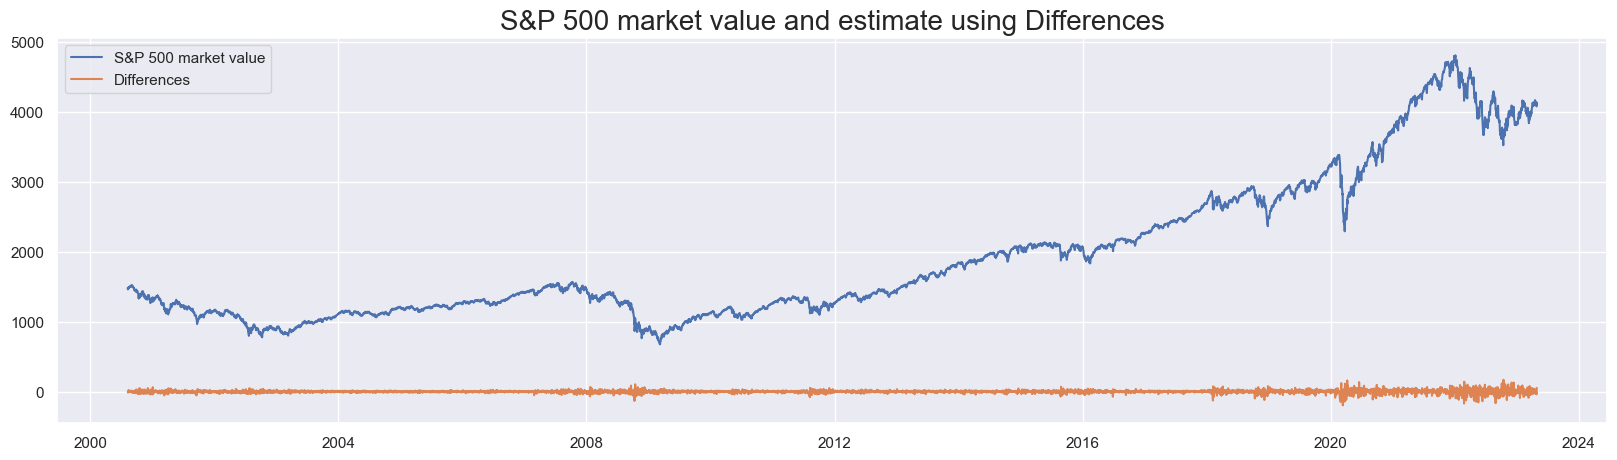

In [165]:
data["diff"] = data['value'].diff(periods = 1)

fig = plt.figure(figsize = (20,5))
plt.plot(data.index, data['value'], label='S&P 500 market value')
plt.plot(data.index, data["diff"], label='Differences')
plt.legend()
plt.title("S&P 500 market value and estimate using Differences", size = 20)
plt.show()

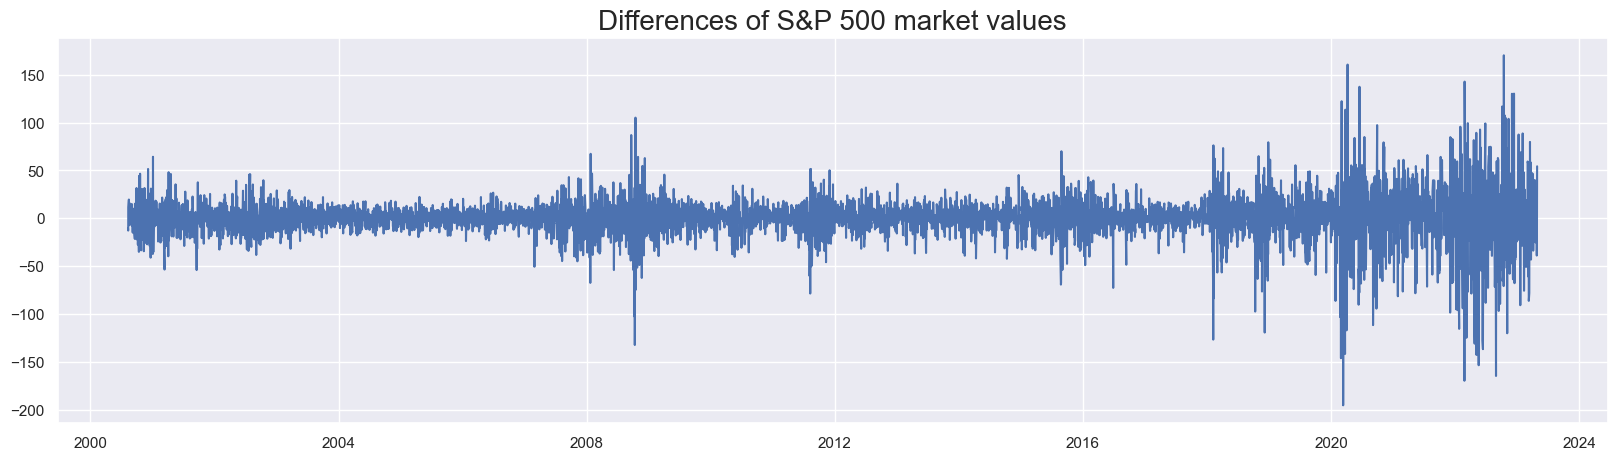

In [166]:
fig = plt.figure(figsize = (20,5))
plt.plot(data.index, data["diff"])
plt.title("Differences of S&P 500 market values", size = 20)
plt.show()

Testing stacionarity of differences of market value (by using Dickey-Fuller test)

In [167]:
sts.adfuller(data["diff"][1:])

(-15.592122626006692,
 1.8744245688760877e-28,
 31,
 5896,
 {'1%': -3.4314595911295664,
  '5%': -2.8620303356963674,
  '10%': -2.567031003464161},
 53281.799921184785)

Again we can see that Dickey-Fuller test suggests stationarity (so we have successfully removed trend)

Comparing results od differencing and Moving Average method

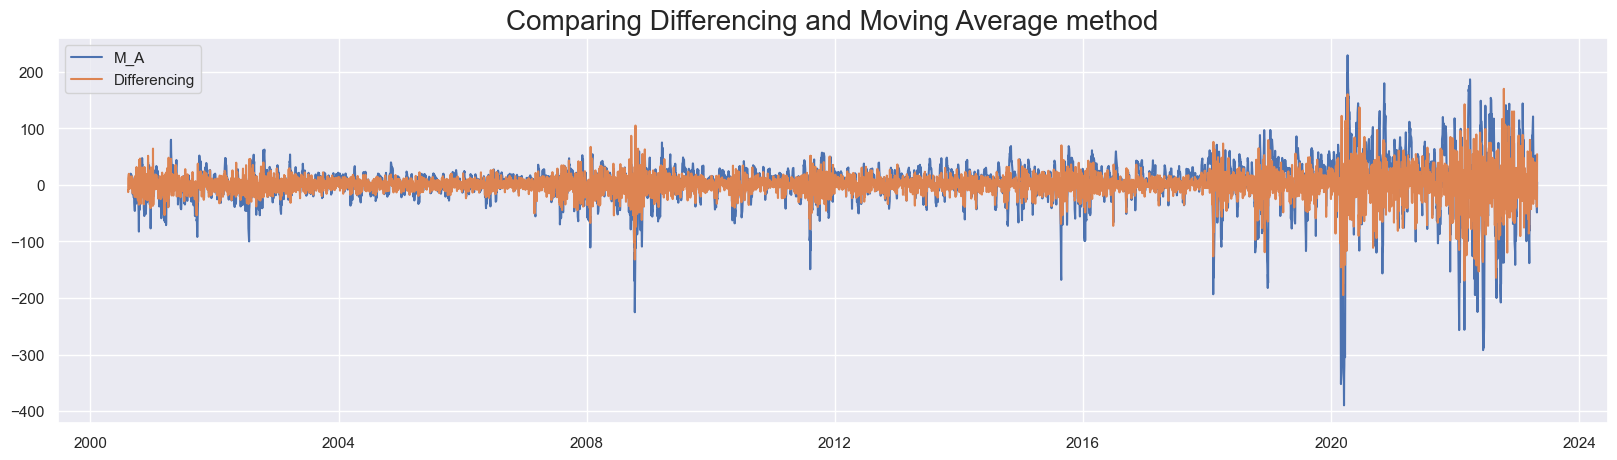

In [168]:
fig = plt.figure(figsize = (20,5))
plt.plot(data.index, data["subs_M_A"], label = "M_A")
plt.plot(data.index, data["diff"], label = "Differencing")
plt.title("Comparing Differencing and Moving Average method", size = 20)
plt.legend()
plt.show()

Based on the results we can see that differencing gives us smaller variance than Moving Average, therefore we shall choose differencing as a method for removing trend.

# 5) Identification of seasonal component's period

## Using function seasonal_decompose to identify seasonal component in S&P 500 market values

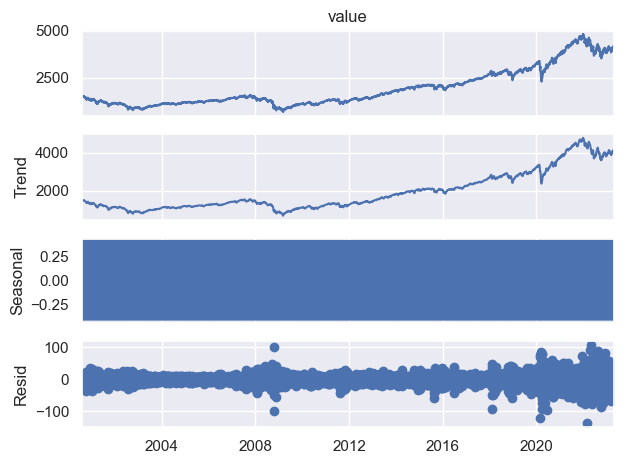

In [169]:
decom_orig_val = seasonal_decompose(data["value"], model = "additive")
decom_orig_val.plot()
plt.show()

This function used Moving Average, we can see that there is no seasonal component detectable. 

## Using function seasonal_decompose to identify seasonal component in S&P 500 market values differences

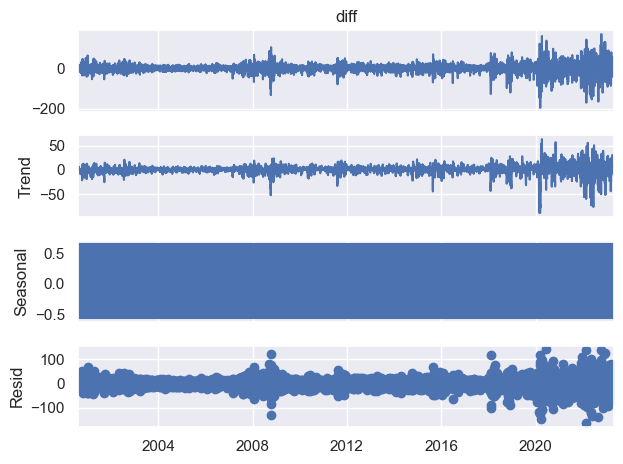

In [170]:
decom_orig_val = seasonal_decompose(data["diff"][1:], model = "additive")
decom_orig_val.plot()
plt.show()

Again we can see that there is no seasonal component detectable. 

## Using periodogram

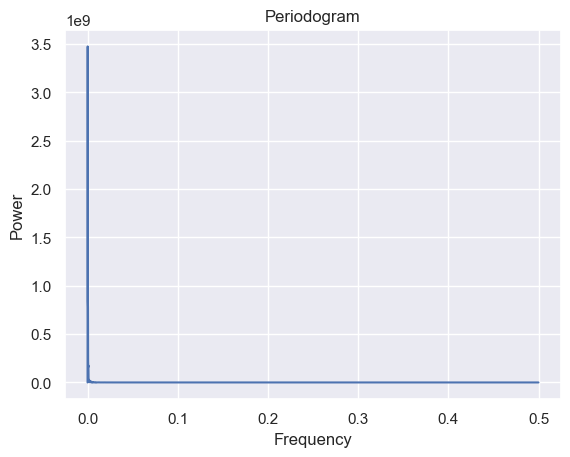

In [171]:
f, Pxx = signal.periodogram(data["value"])
fig, ax = plt.subplots()
ax.plot(f, Pxx)
ax.set_xlabel('Frequency')
ax.set_ylabel('Power')
ax.set_title('Periodogram')
plt.show()

We can see no seasonal component from periodogram

# 6) Determining if given residuals are IID by using randomness test

We have chosen differencing as better sollution to remove trend, but that gives as no residuals so we test residuals from Moving Average(we have saved them as "subs_M_A")

## Looking at autocorrelation function of residuals of Moving Average estimate

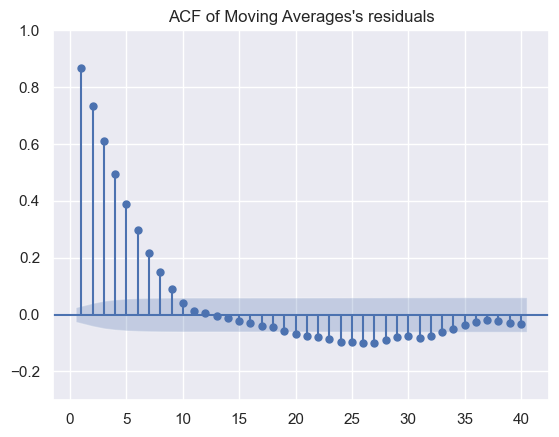

In [172]:
sgt.plot_acf(data["subs_M_A"][12:-12], lags = 40, zero = False)
plt.title("ACF of Moving Averages's residuals")
plt.ylim(-0.3, 1)
plt.show()

We can see that many values are significantly different than zero(are not in blue area) and therefore we can conclude that ACF suggests that residuals are not IID

## Looking at parcial autocorrelation function of residuals of Moving Average estimate

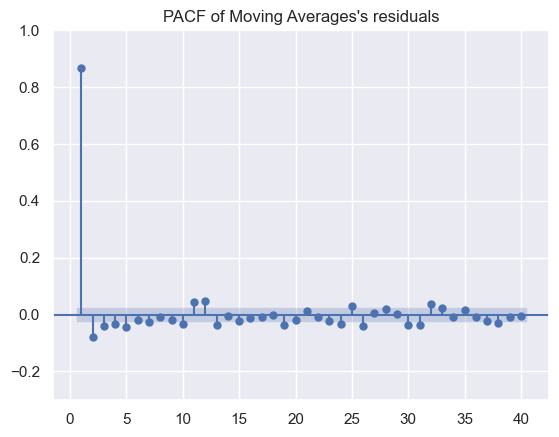

In [173]:
sgt.plot_pacf(data["subs_M_A"][12:-12], lags = 40, zero = False)
plt.title("PACF of Moving Averages's residuals")
plt.ylim(-0.3, 1)
plt.show()

We can see that second lag is almost 1 and also many values are significantly different than zero(are not in blue area) and therefore we can conclude that PACF suggests that residuals are not IID

## Portmanteau test

In [174]:
test_results = acorr_ljungbox(data["subs_M_A"][12:-12], lags = 10)
print(test_results)

         lb_stat  lb_pvalue
1    4456.447622        0.0
2    7643.893888        0.0
3    9837.225205        0.0
4   11287.608830        0.0
5   12182.759078        0.0
6   12702.126110        0.0
7   12975.765119        0.0
8   13105.476018        0.0
9   13154.895093        0.0
10  13164.460744        0.0


Because all p-values are much smaller than 0.05 we can conclude that Portmanteau test rejects hypothesis that residuals are IID

By seeing these results and by looking at graph of residuals we can safely conclude that residuals are not IID

# 7) Autocorrelation functions and partial autocorrelation functions of differences and finding of the best ARMA model

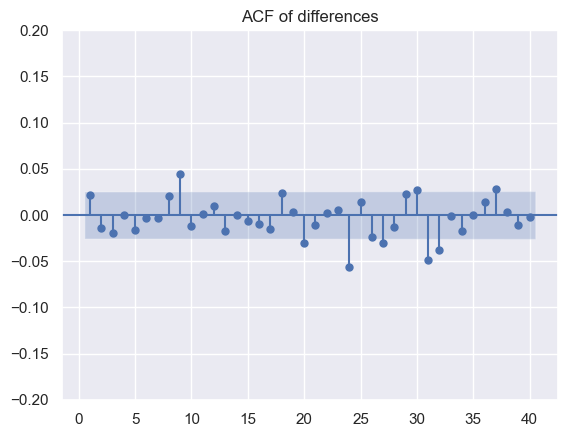

In [175]:
sgt.plot_acf(data["diff"][1:], lags = 40, zero = False)
plt.title("ACF of differences")
plt.ylim(-0.2, 0.2)
plt.show()

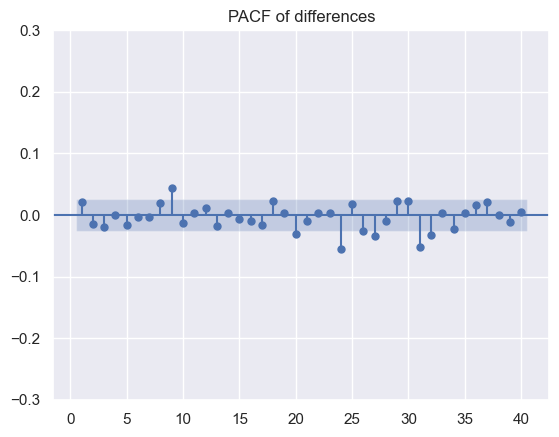

In [176]:
sgt.plot_pacf(data["diff"][1:], lags = 40, zero = False)
plt.title("PACF of differences")
plt.ylim(-0.3, 0.3)
plt.show()

## Finding best ARMA method

Defining function that returns fitted ARMA model of given order

In [177]:
def mod_ARIMA(data, order, start_lags = 8):
    model = ARIMA(endog = data, order = order)
    results = model.fit()
    return model, results

Using auto_arima function to find best ARIMA model for differences

In [178]:
model = auto_arima(data["diff"][1:], start_p=1, start_q=1,
                      test='adf',
                      max_p=10, max_q=10,           
                      d=0,          
                      seasonal=False,   
                      start_P=0, 
                      D=None, 
                      trace=True,
                      error_action='ignore',  
                      suppress_warnings=True, 
                      stepwise=True)

Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=53607.385, Time=0.99 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=53606.616, Time=0.30 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=53605.787, Time=0.30 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=53605.710, Time=0.36 sec
 ARIMA(0,0,2)(0,0,0)[0]             : AIC=53606.773, Time=0.41 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=53607.145, Time=1.16 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=53605.423, Time=0.54 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=53606.228, Time=0.34 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=53607.079, Time=1.30 sec
 ARIMA(0,0,2)(0,0,0)[0] intercept   : AIC=53606.424, Time=0.62 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=53605.499, Time=0.34 sec
 ARIMA(1,0,2)(0,0,0)[0] intercept   : AIC=53606.661, Time=4.15 sec

Best model:  ARIMA(0,0,1)(0,0,0)[0] intercept
Total fit time: 10.813 seconds


In [179]:
best_arima, best_res = mod_ARIMA(data["diff"][1:],(0,0,1))
best_res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                   diff   No. Observations:                 5928
Model:                 ARIMA(0, 0, 1)   Log Likelihood              -26799.711
Date:                Sun, 07 May 2023   AIC                          53605.423
Time:                        21:23:25   BIC                          53625.485
Sample:                    08-09-2000   HQIC                         53612.394
                         - 04-28-2023                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.4465      0.302      1.479      0.139      -0.145       1.038
ma.L1          0.0221      0.006      3.426      0.001       0.009       0.035
sigma2       494.8641      3.771    131.221      0.000     487.473     502.256
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):             24974.55
Prob(Q):                              0.98   Prob(JB):                         0.00
Heteroskedasticity (H):               6.91   Skew:                            -0.58
Prob(H) (two-sided):                  0.00   Kurtosis:                        12.99
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

So we have found that best ARMA model for our differences is MA(1) model. We can see that coeficient ma.L1 has p-value 0.001 which is lesser than 0.05 and is therefore significantly different than zero. 

# 8) Predictions 

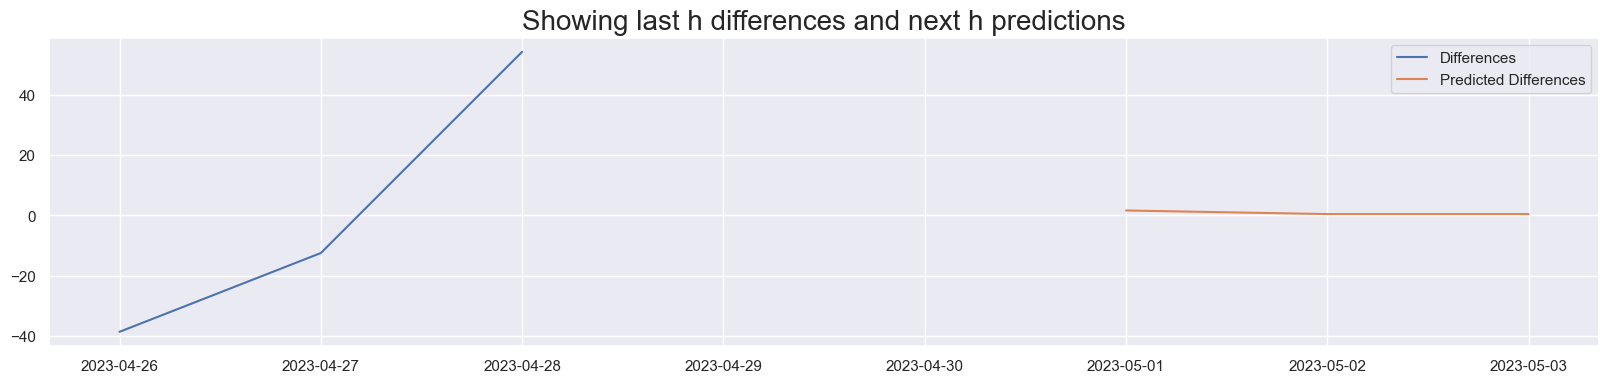

In [180]:
h = 3 #number of predictions
pred_diff = best_res.forecast(steps = h)
fig = plt.figure(figsize = (20,4))
plt.plot(data.index[-h:], data["diff"][-h:], label = "Differences")
plt.plot(pred_diff.index, pred_diff, label = "Predicted Differences")
plt.legend()
plt.title("Showing last h differences and next h predictions",size = 20)
plt.show()

Unfortunatly our loaded data ends with friday so first prediction is monday. Also we can see that predictions do not match our expectations.

# Trying ARIMA models on smaller set of S&P 500 market values

Loading smaller dataset

In [181]:
s_data = raw_data.copy()
s_data = pd.DataFrame(index = pd.to_datetime(s_data["Date"], format = "%m/%d/%y", dayfirst = True), columns = ["value"])
s_data.loc[:,"value"] = raw_data.loc[:," Open"]
s_data = s_data.asfreq("b")
s_data = s_data.fillna(method = "ffill")
s_data = s_data[:] #here we can specify what subset of data we choose
s_data.describe()

,value
count,5929.000000
mean,1915.171154
std,1001.031967
min,675.130000
25%,1181.520000
50%,1436.230000
75%,2462.950000
max,4804.510000


Splitting the Data

In [182]:
size = int(len(s_data)*0.8)
learn_data, test_data = s_data.iloc[:size], s_data.iloc[size:]

Plotting smaller dataset

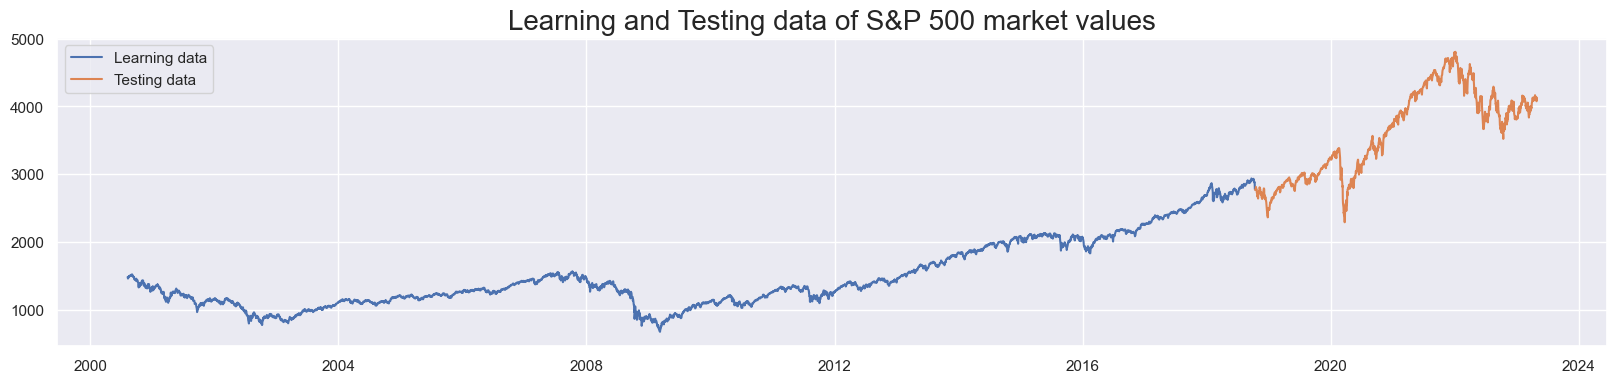

In [183]:
fig = plt.figure(figsize = (20, 4))
plt.plot(learn_data.index, learn_data, label = "Learning data")
plt.plot(test_data.index, test_data, label = "Testing data")
plt.title("Learning and Testing data of S&P 500 market values", size = 20)
plt.legend()
plt.show()

Finding optimal ARIMA model

In [184]:
model = auto_arima(learn_data, start_p=1, start_q=1,
                      test='adf',
                      max_p=5, max_q=5,
                      m=1,             
                      d=1,          
                      seasonal=False,   
                      start_P=0, 
                      D=None, 
                      trace=True,
                      error_action='ignore',  
                      suppress_warnings=True, 
                      stepwise=True)

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=38872.362, Time=1.30 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=38884.714, Time=0.29 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=38882.533, Time=0.31 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=38881.956, Time=0.45 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=38884.372, Time=0.48 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=38868.596, Time=0.83 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=38866.646, Time=0.45 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=38868.594, Time=0.52 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=38870.595, Time=0.58 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=38866.667, Time=0.30 sec

Best model:  ARIMA(2,1,0)(0,0,0)[0] intercept
Total fit time: 5.508 seconds


In [185]:
mod, result = mod_ARIMA(learn_data, (2,1,0))
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  value   No. Observations:                 4743
Model:                 ARIMA(2, 1, 0)   Log Likelihood              -19430.333
Date:                Sun, 07 May 2023   AIC                          38866.667
Time:                        21:23:40   BIC                          38886.059
Sample:                    08-08-2000   HQIC                         38873.482
                         - 10-11-2018                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0313      0.008     -3.987      0.000      -0.047      -0.016
ar.L2         -0.0612      0.007     -8.721      0.000      -0.075      -0.047
sigma2       212.1460      2.064    102.759      0.000     208.100     216.192
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):             10461.84
Prob(Q):                              0.99   Prob(JB):                         0.00
Heteroskedasticity (H):               1.64   Skew:                            -0.61
Prob(H) (two-sided):                  0.00   Kurtosis:                        10.17
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

## Showing predictions

Showing full prediction vs test_data

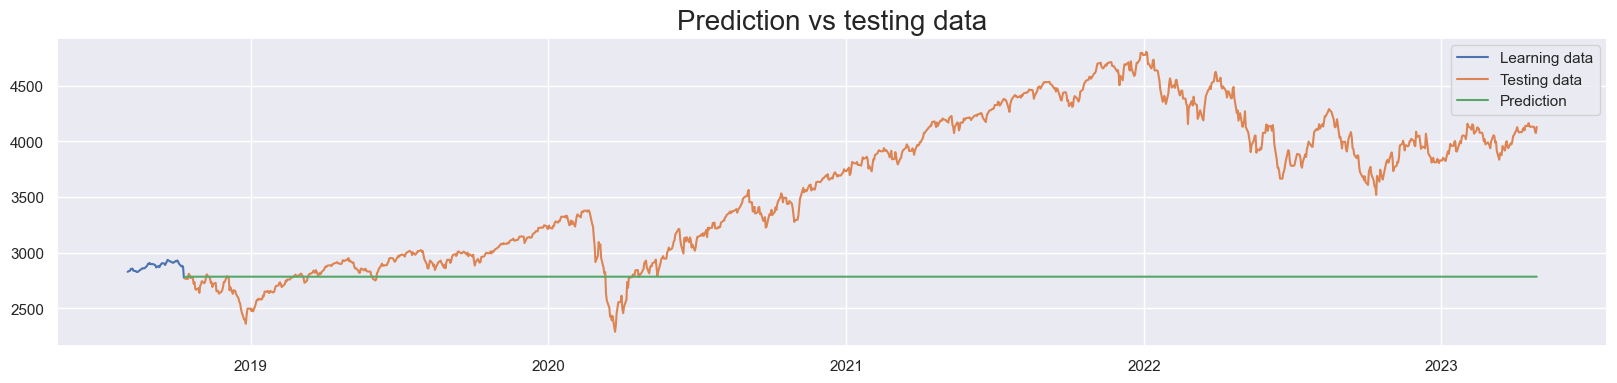

In [186]:
fig = plt.figure(figsize = (20, 4))
plt.plot(learn_data.index[-50:], learn_data[-50:], label = "Learning data")
plt.plot(test_data.index, test_data, label = "Testing data")
plt.plot(test_data.index, result.forecast(len(test_data.index)), label = "Prediction")
plt.title("Prediction vs testing data", size = 20)
plt.legend()
plt.show()

Showing first h predictions vs test_data

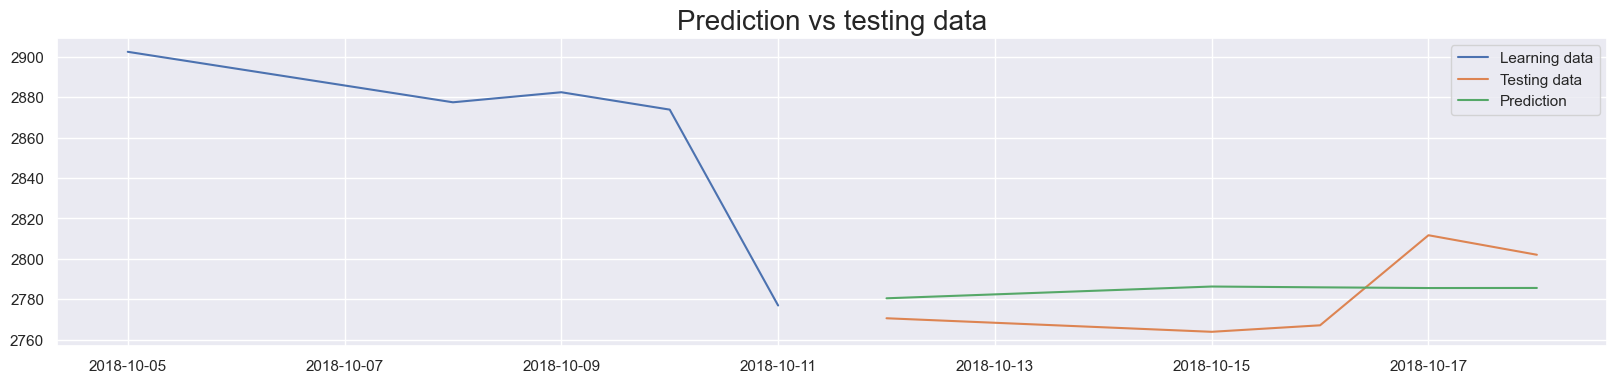

In [187]:
h = 5
fig = plt.figure(figsize = (20, 4))
plt.plot(learn_data.index[-h:], learn_data[-h:], label = "Learning data")
plt.plot(test_data.index[:h], test_data[:h], label = "Testing data")
plt.plot(test_data.index[:h], result.forecast(h), label = "Prediction")
plt.title("Prediction vs testing data", size = 20)
plt.legend()
plt.show()